## This page uses compares logistic regression and other classification models for modeling several economic variables from census data to understand the drivers of voting results.

Classification models:
- Logistic regression

In [38]:
# imports
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings

In [39]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
np.random.seed(42)

In [88]:
# modeling imports
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Logistic Regression classifier, to learn feature importance.

Y = outcome of congressional vote:  
- 0 = REP, because has traditionally been the baseline.
- 1 = DEM, because this is a new trend.

#### Bring in transformed data set, which combines voting and census data for each precinct

In [41]:
df = pd.read_pickle('./data/combined18_extended.pkl')
df.shape

(1334, 37)

In [42]:
df.head()

,srprec_orig,subindex,pctsrprec_tract,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,...,totreg_r,dem,rep,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,2001.0,3.0,100.0,2647.0,161.0,0.0,1372.0,1152.0,268.0,783.0,...,371.0,161.0,106.0,83.0,173.0,198.0,106.0,20.0,56.0,7.0
1,2002.0,0.0,100.0,2881.0,217.0,9.0,1525.0,1030.0,257.0,1082.0,...,109.0,61.0,8.0,39.0,46.0,63.0,52.0,0.0,23.0,0.0
2,2008.0,0.0,100.0,3948.0,278.0,0.0,1438.0,1656.0,561.0,677.0,...,1197.0,621.0,234.0,301.0,574.0,623.0,376.0,60.0,171.0,12.0
3,2009.0,3.0,100.0,3045.0,147.0,0.0,2459.0,1447.0,273.0,717.0,...,735.0,380.0,177.0,160.0,359.0,376.0,169.0,39.0,54.0,1.0
4,2011.0,0.0,100.0,2991.0,74.0,0.0,1401.0,1486.0,334.0,492.0,...,805.0,251.0,360.0,167.0,415.0,390.0,59.0,29.0,30.0,5.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   srprec_orig               1334 non-null   float64
 1   subindex                  1334 non-null   float64
 2   pctsrprec_tract           1334 non-null   float64
 3   employed_wgt              1334 non-null   float64
 4   unemployed_wgt            1334 non-null   float64
 5   empl_military_wgt         1334 non-null   float64
 6   not_inlaborforce_wgt      1334 non-null   float64
 7   working_women_wgt         1334 non-null   float64
 8   parents_work_under6_wgt   1334 non-null   float64
 9   parents_work_0617_wgt     1334 non-null   float64
 10  occ_mgmt_sci_art_wgt      1334 non-null   float64
 11  occ_service_sector_wgt    1334 non-null   float64
 12  occ_sales_gen_office_wgt  1334 non-null   float64
 13  occ_constr_maintc_wgt     1334 non-null   float64
 14  occ_manu

In [44]:
df['srprec_orig'] = df['srprec_orig'].astype('int64')

In [45]:
df['cddist'].value_counts()

45    347
48    334
39    226
46    198
47    133
49     87
38      9
Name: cddist, dtype: int64

### Define X and y from voter data (can enhance with census data later on)

#### define y

In [46]:
# create a categorical column where CNGREP01 < CNGDEM01  (where Democrat wins, since Dems were victorious in 2018)

In [47]:
y_raw18 = combo[['CNGDEM01', 'CNGREP01']]
y_raw18.head()

,CNGDEM01,CNGREP01
0,249,126
1,100,17
2,929,295
3,515,229
4,368,439


In [48]:
y_raw18.describe()

,CNGDEM01,CNGREP01
count,1334.000000,1334.000000
mean,435.853073,368.841829
std,301.603744,284.835099
min,0.000000,0.000000
25%,187.750000,129.250000
50%,415.000000,327.500000
75%,641.000000,566.750000
max,1806.000000,1475.000000


In [49]:
y_raw18['dem_win'] = combo['CNGDEM01'] > combo['CNGREP01']
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-49-fc75eef615fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = combo['CNGDEM01'] > combo['CNGREP01']


In [50]:
y_raw18

,CNGDEM01,CNGREP01,dem_win
0,249,126,True
1,100,17,True
2,929,295,True
3,515,229,True
4,368,439,False
...,...,...,...
1329,225,495,False
1330,28,49,False
1331,93,154,False
1332,75,173,False


In [58]:
y_raw18['dem_win'].value_counts(normalize=True)
#slightly unbalanced 60/40, but not horrible

1    0.604948
0    0.395052
Name: dem_win, dtype: float64

In [52]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   bool 
dtypes: bool(1), int64(2)
memory usage: 32.6 KB


In [53]:
y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-53-8b3119850fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)


In [54]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   int64
dtypes: int64(3)
memory usage: 41.7 KB


In [67]:
y = y_raw18['dem_win']
y.head()

0    1
1    1
2    1
3    1
4    0
Name: dem_win, dtype: int64

In [112]:
y.to_pickle('./data/y.pkl')

In [60]:
df.columns.tolist()

['srprec_orig',
 'subindex',
 'pctsrprec_tract',
 'employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
 'county',
 'srprec',
 'cddist',
 'TOTREG',
 'TOTVOTE',
 'CNGDEM01',
 'CNGREP01',
 'election',
 'totreg_r',
 'dem',
 'rep',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [64]:
X = df[['employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
 'TOTREG',
 'TOTVOTE',
 'dem',
 'rep',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']]


In [65]:
X.head()

,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,occ_mgmt_sci_art_wgt,occ_service_sector_wgt,occ_sales_gen_office_wgt,...,TOTVOTE,dem,rep,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,2647.0,161.0,0.0,1372.0,1152.0,268.0,783.0,244.0,637.0,706.0,...,381,161.0,106.0,83.0,173.0,198.0,106.0,20.0,56.0,7.0
1,2881.0,217.0,9.0,1525.0,1030.0,257.0,1082.0,363.0,573.0,383.0,...,123,61.0,8.0,39.0,46.0,63.0,52.0,0.0,23.0,0.0
2,3948.0,278.0,0.0,1438.0,1656.0,561.0,677.0,675.0,796.0,1064.0,...,1295,621.0,234.0,301.0,574.0,623.0,376.0,60.0,171.0,12.0
3,3045.0,147.0,0.0,2459.0,1447.0,273.0,717.0,693.0,701.0,912.0,...,772,380.0,177.0,160.0,359.0,376.0,169.0,39.0,54.0,1.0
4,2991.0,74.0,0.0,1401.0,1486.0,334.0,492.0,1364.0,331.0,1011.0,...,829,251.0,360.0,167.0,415.0,390.0,59.0,29.0,30.0,5.0


In [113]:
X.to_pickle('./data/X.pkl')

#### run the extended dataset through LogReg, no scaling


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head(3)

,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,occ_mgmt_sci_art_wgt,occ_service_sector_wgt,occ_sales_gen_office_wgt,...,TOTVOTE,dem,rep,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
1188,4875.0,253.0,0.0,1959.0,2191.0,711.0,1432.0,3132.0,286.0,1234.0,...,1306,395.0,534.0,323.0,653.0,651.0,44.0,23.0,32.0,7.0
906,2414.0,127.0,0.0,1811.0,1088.0,165.0,321.0,1518.0,175.0,613.0,...,1717,259.0,1041.0,315.0,750.0,915.0,12.0,17.0,8.0,1.0
1018,2771.0,115.0,0.0,1595.0,1284.0,178.0,326.0,1347.0,443.0,690.0,...,943,318.0,311.0,232.0,398.0,510.0,58.0,27.0,31.0,3.0


In [69]:
import sklearn

In [70]:
logreg = LogisticRegression(n_jobs=-1, max_iter=10_000)

In [71]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1)

In [72]:
logreg.score(X_train, y_train)

0.7

In [73]:
logreg.score(X_test, y_test)

0.655688622754491

In [74]:
f1_train = f1_score(y_train, logreg.predict(X_train))
f1_test = f1_score(y_test, logreg.predict(X_test))
overfit = f1_train > f1_test
round(f1_train, 4), round(f1_test, 4), overfit

(0.7717, 0.7294, True)

In [76]:
# vs. null model?  
y_test.value_counts(normalize=True)

# our logreg score (65%) is slightly better than null model (60%), but not great.  

1    0.598802
0    0.401198
Name: dem_win, dtype: float64

#### Examine feature importance:

In [77]:
logreg.coef_

array([[ 4.92992036e-04,  6.30289245e-05, -2.49404628e-06,
         1.77492779e-06,  2.37214234e-04,  5.54363194e-05,
         7.77912447e-05, -6.86096068e-05,  2.59448145e-04,
         3.06358312e-06,  6.82990593e-05,  2.30644684e-04,
         5.31388680e-09, -5.01669841e-04,  5.49498815e-04,
         4.33207632e-04,  7.94327698e-06, -2.30614192e-04,
         1.39141289e-04, -4.08035405e-04,  2.34601238e-05,
        -1.20898994e-04, -1.28264114e-04,  1.10442240e-04,
        -1.05864541e-05,  3.56812125e-05,  3.59526150e-06]])

In [78]:
np.exp(logreg.coef_)

array([[1.00049311, 1.00006303, 0.99999751, 1.00000177, 1.00023724,
        1.00005544, 1.00007779, 0.99993139, 1.00025948, 1.00000306,
        1.0000683 , 1.00023067, 1.00000001, 0.99949846, 1.00054965,
        1.0004333 , 1.00000794, 0.99976941, 1.00013915, 0.99959205,
        1.00002346, 0.99987911, 0.99987174, 1.00011045, 0.99998941,
        1.00003568, 1.0000036 ]])

In [79]:
features = X.columns.to_list()
features

['employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
 'TOTREG',
 'TOTVOTE',
 'dem',
 'rep',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [80]:
logreg_coef = pd.DataFrame({'columns':features, 'coef':logreg.coef_[0]})


In [81]:
viz = logreg_coef.sort_values('coef')
viz

,columns,coef
13,hlthins_priv_wgt,-5.016698e-04
19,rep,-4.080354e-04
17,TOTVOTE,-2.306142e-04
22,female,-1.282641e-04
21,male,-1.208990e-04
7,occ_mgmt_sci_art_wgt,-6.860961e-05
24,hisprep,-1.058645e-05
2,empl_military_wgt,-2.494046e-06
12,hh_med_income_wgt,5.313887e-09
3,not_inlaborforce_wgt,1.774928e-06


Text(0, 0.5, 'feature')

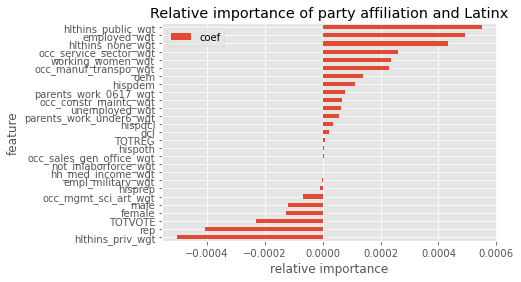

In [82]:
viz.plot(kind='barh', x='columns', y='coef').legend(
    loc='best', ncol=3)
plt.title("Relative importance of party affiliation and Latinx")
plt.xlabel("relative importance")
plt.ylabel("feature")
# plt.yticks(viz['columns'].tolist());

In [ ]:
# model evaluation scores are below.

#### Conclusions:
1. overfits
2. lower model scores (approx 60%) vs voting data only (approx 90%) (party affiliation, gender, etc.).

#### scale the data because they are not on the same scale:
1. `hh_med_income_wgt` is in dollars
2. other fields are expressed as population numbers, however may be of different scales. best to standardize the scale of the data

In [86]:
ss = StandardScaler()

In [90]:
#estimators
logreg2 = LogisticRegression()
dtree = DecisionTreeClassifier()
hist = HistGradientBoostingClassifier()

In [118]:
ss_logreg2 = make_pipeline(ss, logreg2)
ss_dtree = make_pipeline(ss, dtree)
ss_hist = make_pipeline(ss, hist)
for est in (ss_logreg2, ss_dtree, ss_hist):
    est.fit(X_train, y_train)
    print(f'The Score on the train data is: {est.score(X_train, y_train)}')
    print(f'The Score on the test data is: {est.score(X_test, y_test)}')


The Score on the train data is: 0.906
The Score on the test data is: 0.907185628742515
The Score on the train data is: 1.0
The Score on the test data is: 0.811377245508982
The Score on the train data is: 1.0
The Score on the test data is: 0.8772455089820359


**OBSERVATIONS**
- Gradient Boost also has decent results on test data:  88%
- For LogReg, scaling the data greatly improved the scores, from approx 65-70% to 90%

### Further tuning via feature selection (Polynomial Features, Select K Best, PCA, Decision Tree)

#### Polynomial features with logistic regression
**RESULT** Overfits the data, by a lot

In [122]:
pf = PolynomialFeatures()
logreg3 = LogisticRegression(max_iter=10_000)

In [123]:
pf_logreg3 = make_pipeline(ss, pf, logreg3)

pf_logreg3.fit(X_train, y_train)
print(f'The Score on the train data is: {est.score(X_train, y_train)}')
print(f'The Score on the test data is: {est.score(X_test, y_test)}')

The Score on the train data is: 1.0
The Score on the test data is: 0.8772455089820359


In [191]:
# DataFrame of coefficients
# pd.DataFrame(list(zip(X.columns, logreg3.coef_)))

#### Select K best features
Grid Search over a few options

In [174]:
ss4 = StandardScaler()
pf4 = PolynomialFeatures()
select = SelectKBest()
logreg4 = LogisticRegression()

In [175]:
pf_logreg4 = make_pipeline(ss4, pf4, select, logreg4)

In [176]:
params = {
    'selectkbest__k': range(5,25,100),
    'logisticregression__penalty': ['none', 'l2'],
    'logisticregression__max_iter':[100000]
}

In [177]:
gs = GridSearchCV(pf_logreg4, param_grid=params)
gs.fit(X_train, y_train)

#returns a warning regarding ("Features %s are constant.")
# very little data in X_train['empl_military_wgt'] ... OK to drop this feature

/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features 

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__max_iter': [100000],
                         'logisticregression__penalty': ['none', 'l2'],
                         'selectkbest__k': range(5, 25, 100)})

In [194]:
X_train['empl_military_wgt'].value_counts()

0.0      828
10.0      14
4.0       12
2.0       11
5.0       11
16.0       9
6.0        9
3.0        8
14.0       8
13.0       7
17.0       7
9.0        7
1.0        6
8.0        6
7.0        5
12.0       5
29.0       4
18.0       4
33.0       4
15.0       4
30.0       3
25.0       3
57.0       3
44.0       3
24.0       3
19.0       2
26.0       2
49.0       2
116.0      2
27.0       1
35.0       1
11.0       1
40.0       1
20.0       1
41.0       1
36.0       1
32.0       1
Name: empl_military_wgt, dtype: int64

In [184]:
print('Train Best', gs.best_score_)
print('Test Score', gs.score(X_test, y_test))
print(gs.best_params_)
print(gs.best_estimator_)


Train Best 0.716
Test Score 0.7335329341317365
{'logisticregression__max_iter': 100000, 'logisticregression__penalty': 'none', 'selectkbest__k': 5}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest', SelectKBest(k=5)),
                ('logisticregression',
                 LogisticRegression(max_iter=100000, penalty='none'))])


In [186]:
# DataFrame of coefficients
pd.DataFrame(list(zip(X.columns, gs.best_estimator_.named_steps['logisticregression'].coef_)))

,0,1
0,employed_wgt,"[0.04281284470997387, 0.2489699996436624, 0.15..."


## Model evaluation

In [161]:
def rmse_model(model):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {model} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

#### model-only rmse

In [163]:
rmse_model(logreg2)
# winner!  logistic regression w/ scaling
# while overfit, it is not by that much

'for LogisticRegression() rmse_train = 0.6284902544988268, and rmse_test = 0.6381109846590285.  Overfit = True'

In [164]:
rmse_model(dtree)

'for DecisionTreeClassifier() rmse_train = 0.6164414002968976, and rmse_test = 0.6142031496028296.  Overfit = False'

In [165]:
rmse_model(hist)

'for HistGradientBoostingClassifier() rmse_train = 0.6024948132556828, and rmse_test = 0.5968981698327618.  Overfit = False'

In [166]:
rmse_model(logreg)

'for LogisticRegression(max_iter=10000, n_jobs=-1) rmse_train = 0.5477225575051661, and rmse_test = 0.5867805188019699.  Overfit = True'

#### pipeline rmse

In [168]:
def rmse_pipe(pipe):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, pipe.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {pipe} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

In [169]:
rmse_pipe(ss_logreg2)
# logreg2 still a winner!  

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('logisticregression', LogisticRegression())]) rmse_train = 0.3065941943351178, and rmse_test = 0.3046545113033533.  Overfit = False"

In [170]:
rmse_pipe(ss_dtree)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('decisiontreeclassifier', DecisionTreeClassifier())]) rmse_train = 0.0, and rmse_test = 0.4343072121102964.  Overfit = True"

In [171]:
rmse_pipe(ss_hist)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('histgradientboostingclassifier',\n                 HistGradientBoostingClassifier())]) rmse_train = 0.0, and rmse_test = 0.3503633699717538.  Overfit = True"

In [173]:
rmse_pipe(pf_logreg3)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('polynomialfeatures', PolynomialFeatures()),\n                ('logisticregression', LogisticRegression(max_iter=10000))]) rmse_train = 0.2449489742783178, and rmse_test = 0.33283395727265036.  Overfit = True"

In [181]:
def rmse_gs(grid):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, grid.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, grid.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {grid} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

In [182]:
rmse_gs(gs)

"for GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),\n                                       ('polynomialfeatures',\n                                        PolynomialFeatures()),\n                                       ('selectkbest', SelectKBest()),\n                                       ('logisticregression',\n                                        LogisticRegression())]),\n             param_grid={'logisticregression__max_iter': [100000],\n                         'logisticregression__penalty': ['none', 'l2'],\n                         'selectkbest__k': range(5, 25, 100)}) rmse_train = 0.5244044240850758, and rmse_test = 0.5162044806743384.  Overfit = False"

**CONCLUSION**

Loading all of these factors into a gridsearch removes the overfitting, however RMSE is much higher (52% vs 30% for logreg + standard scaler)